In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import os
import glob

2024-06-28 14:23:25.313593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 14:23:25.819617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from os import listdir
from os.path import isfile, join

dataset = pd.concat(map(pd.read_csv, glob.glob('/mnt/c/Users/aardp/Downloads/trainG3/*.csv')))
dataset.head()

,Year/Month,Box Size,Longitude,Latitude,PID2: Standard/Enhanced,Group,Checksum,S-S1,S-Median,S-S5,...,R-S1,R-Median,R-S5,R-Mean,R-Observation number,R-Standard deviation,R-Mean day of the month,R-Fraction of daylight observations,R-Mean Longitude,R-Mean Latitude
0,1950/1,2,16.0,70.0,0,3,10,5.87,6.2,6.3,...,72.0,87.7,92.7,84.2,12,9.6,20,0.0,0.6,0.1
1,1950/1,2,14.0,68.0,0,3,6,6.20,7.1,7.4,...,60.0,82.5,93.4,76.9,18,16.0,22,0.0,0.7,0.7
2,1950/1,2,16.0,68.0,0,3,13,6.20,6.2,6.2,...,65.1,71.9,78.7,71.9,2,14.1,20,0.0,0.3,0.8
3,1950/1,2,0.0,66.0,0,3,1,5.60,6.4,7.2,...,68.4,85.0,100.0,83.5,88,12.3,10,0.1,0.9,0.0
4,1950/1,2,2.0,66.0,0,3,8,6.70,7.2,7.8,...,68.2,84.7,92.7,82.3,128,13.1,20,0.1,0.1,0.1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3297158 entries, 0 to 5386
Data columns (total 47 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Year/Month                           object 
 1   Box Size                             int64  
 2   Longitude                            float64
 3   Latitude                             float64
 4   PID2: Standard/Enhanced              int64  
 5   Group                                int64  
 6   Checksum                             int64  
 7   S-S1                                 float64
 8   S-Median                             float64
 9   S-S5                                 float64
 10  S-Mean                               float64
 11  S-Observation number                 int64  
 12  S-Standard deviation                 float64
 13  S-Mean day of the month              int64  
 14  S-Fraction of daylight observations  float64
 15  S-Mean Longitude                     flo

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-28 14:23:45.445415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 14:23:45.463295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 14:23:45.463349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# Load the data
df = dataset

# Display the first few rows of the dataframe
print(df.head())

# Display information about the dataframe
print(df.info())

# Display statistical summary
print(df.describe())

# Check for any remaining NaN values
print(df.isna().sum())

# Remove rows with NaN values (if any)
df.dropna(inplace=True)

df['Longitude'] = df['Longitude'].apply(lambda x: x - 360 if x > 180 else x)

# Extract temporal features from 'Year/Month'
df['Year/Month'] = pd.to_datetime(df['Year/Month'], format='%Y/%m')
df['Year'] = df['Year/Month'].dt.year
df['Month'] = df['Year/Month'].dt.month

# Drop the original 'Year/Month' column
#df.drop(columns=['Year/Month'], inplace=True)

# Check for any NaN values after pivoting
print(df.isna().sum())

# Handle missing values
df.fillna(method='ffill', inplace=True)

  Year/Month  Box Size  Longitude  Latitude  PID2: Standard/Enhanced  Group  \
0     1950/1         2       16.0      70.0                        0      3   
1     1950/1         2       14.0      68.0                        0      3   
2     1950/1         2       16.0      68.0                        0      3   
3     1950/1         2        0.0      66.0                        0      3   
4     1950/1         2        2.0      66.0                        0      3   

   Checksum  S-S1  S-Median  S-S5  ...  R-S1  R-Median   R-S5  R-Mean  \
0        10  5.87       6.2   6.3  ...  72.0      87.7   92.7    84.2   
1         6  6.20       7.1   7.4  ...  60.0      82.5   93.4    76.9   
2        13  6.20       6.2   6.2  ...  65.1      71.9   78.7    71.9   
3         1  5.60       6.4   7.2  ...  68.4      85.0  100.0    83.5   
4         8  6.70       7.2   7.8  ...  68.2      84.7   92.7    82.3   

   R-Observation number  R-Standard deviation  R-Mean day of the month  \
0           

Year/Month                             0
Box Size                               0
Longitude                              0
Latitude                               0
PID2: Standard/Enhanced                0
Group                                  0
Checksum                               0
S-S1                                   0
S-Median                               0
S-S5                                   0
S-Mean                                 0
S-Observation number                   0
S-Standard deviation                   0
S-Mean day of the month                0
S-Fraction of daylight observations    0
S-Mean Longitude                       0
S-Mean Latitude                        0
A-S1                                   0
A-Median                               0
A-S5                                   0
A-Mean                                 0
A-Observation number                   0
A-Standard deviation                   0
A-Mean day of the month                0
A-Fraction of da

/tmp/ipykernel_8601/1347463728.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


/home/innobridge/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-28 14:23:51.123285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 14:23:51.123355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 14:23:51.123393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_no

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1719599032.512145    8836 service.cc:145] XLA service 0x7f637000b980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719599032.512182    8836 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-28 14:23:52.526874: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-28 14:23:52.588642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


  148/82429 ━━━━━━━━━━━━━━━━━━━━ 1:24 1ms/step - loss: 355.9449 - mae: 17.2575  

I0000 00:00:1719599032.977065    8836 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82429/82429 ━━━━━━━━━━━━━━━━━━━━ 112s 1ms/step - loss: 10.7544 - mae: 1.5142 - val_loss: 0.9923 - val_mae: 0.7196
Epoch 2/5
82429/82429 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.9757 - mae: 0.7138 - val_loss: 0.9184 - val_mae: 0.6929
Epoch 3/5
82429/82429 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - loss: 0.9038 - mae: 0.6889 - val_loss: 0.8584 - val_mae: 0.6709
Epoch 4/5
82429/82429 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.8461 - mae: 0.6667 - val_loss: 0.8088 - val_mae: 0.6509
Epoch 5/5
82429/82429 ━━━━━━━━━━━━━━━━━━━━ 112s 1ms/step - loss: 0.8069 - mae: 0.6505 - val_loss: 0.7795 - val_mae: 0.6395
20608/20608 ━━━━━━━━━━━━━━━━━━━━ 19s 934us/step - loss: 0.7744 - mae: 0.6384
Validation Loss: [0.779484212398529, 0.6395015716552734]
82429/82429 ━━━━━━━━━━━━━━━━━━━━ 78s 941us/step - loss: 0.7786 - mae: 0.6395
Training Loss: [0.7788293957710266, 0.6393519639968872]


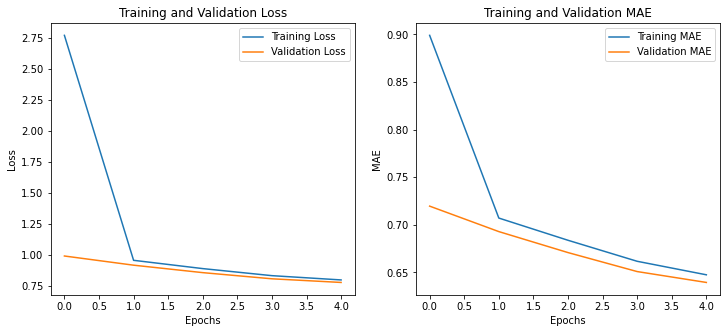

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
# Assuming `df` is your DataFrame
# Extracting relevant columns
X = df[['Year', 'Month', 'Box Size', 'Longitude', 'Latitude', 'S-Mean', 'A-Mean', 'Q-Mean', 'R-Mean']]  # Example numerical features
y = df['S-Mean']  # Mean-S as the target variable

# Normalizing numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Building the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='sigmoid'),
    Dense(1)  # Output layer, 1 neuron for regression task
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

# Reshaping input for Conv1D (adding the channel dimension)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=32, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])

# Assuming `model` is your trained CNN model
# Evaluate the model on the validation set
loss = model.evaluate(X_val_reshaped, y_val)

print(f'Validation Loss: {loss}')

# Optionally, you can also evaluate on the training set
train_loss = model.evaluate(X_train_reshaped, y_train)
print(f'Training Loss: {train_loss}')

# Plot the training and validation loss and MAE
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [8]:
dataset_test = pd.concat(map(pd.read_csv, glob.glob('/mnt/c/Users/aardp/Downloads/testG3/*.csv')))
dataset_test.head()

,Year/Month,Box Size,Longitude,Latitude,PID2: Standard/Enhanced,Group,Checksum,S-S1,S-Median,S-S5,...,R-S1,R-Median,R-S5,R-Mean,R-Observation number,R-Standard deviation,R-Mean day of the month,R-Fraction of daylight observations,R-Mean Longitude,R-Mean Latitude
0,2001/1,2,10.0,76.0,0,3,5,2.80,2.80,2.80,...,81.8,82.3,82.8,82.3,2,1.0,12,0.0,0.4,0.7
1,2001/1,2,12.0,76.0,0,3,2,1.15,1.25,1.35,...,86.6,87.2,87.9,87.2,2,1.4,14,0.0,0.2,0.6
2,2001/1,2,14.0,74.0,0,3,9,3.33,3.50,6.19,...,73.0,78.8,87.0,79.4,12,7.3,26,0.0,0.6,0.5
3,2001/1,2,16.0,74.0,0,3,9,3.00,3.50,4.42,...,77.2,83.9,90.6,83.9,2,13.9,20,0.0,0.3,0.1
4,2001/1,2,18.0,74.0,0,3,14,2.87,3.00,4.50,...,88.9,93.7,95.1,92.0,3,4.7,14,0.0,0.6,0.1


In [9]:
# Load your new dataset for prediction (modify as per your data loading method)

# dataset_test['Longitude'] = dataset_test['Longitude'].apply(lambda x: x - 360 if x > 180 else x)

# Example assuming X_test contains the test data and y_test contains the ground truth labels

dataset_test['Year/Month'] = pd.to_datetime(dataset_test['Year/Month'], format='%Y/%m')
dataset_test['Year'] = dataset_test['Year/Month'].dt.year
dataset_test['Month'] = dataset_test['Year/Month'].dt.month

X_test = dataset_test[['Year', 'Month', 'Box Size', 'Longitude', 'Latitude', 'A-Mean', 'Q-Mean', 'R-Mean']]
y_test = dataset_test['S-Mean']

# Normalize the input data (if necessary)
X_test = X_test / 255.0  # Assuming pixel values are in the range [0, 255]

# Reshape data if necessary (e.g., for grayscale images)
# X_test = X_test.reshape((-1, height, width, channels))

# Optionally, convert to TensorFlow tensor (depending on how your model expects input)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


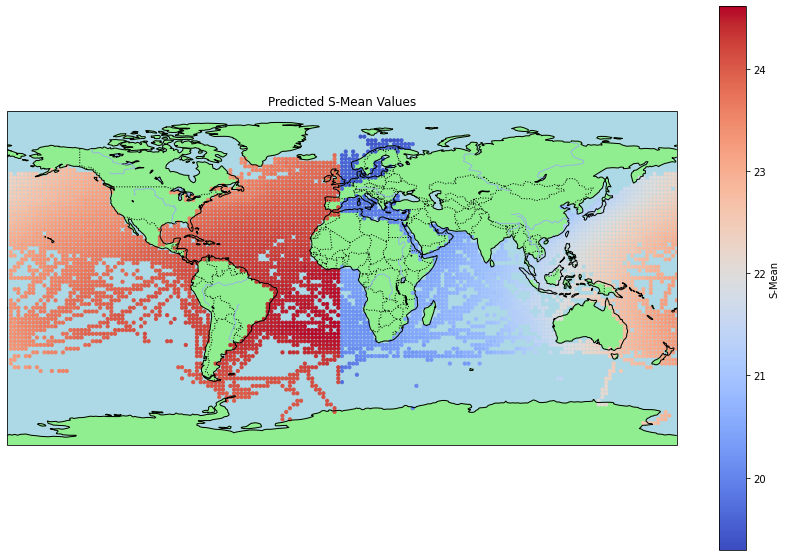

In [20]:
# Make predictions
predictions = model.predict(X_test_tf)

# Assuming predictions contain the predicted SST values (modify as per your output)
predicted_sst = predictions.flatten()  # Flatten predictions if necessary

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Function to plot the world map with predicted values
def plot_world_map(data, variable, title, actualorprediction):
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add map features first
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.LAND, color='lightgreen', edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    ax.add_feature(cfeature.RIVERS)
    ax.set_extent([-180, 180, -90, 90])

    # Now plot the scatter points
    scatter = ax.scatter(data['Longitude'], data['Latitude'], c=actualorprediction, cmap='coolwarm', 
                         s=10, transform=ccrs.PlateCarree())
    plt.colorbar(scatter, label=f'{variable}')
    plt.title(f'{title}')
    plt.show()

# Plot the predicted values for each variable
plot_world_map(dataset_test, 'S-Mean', 'Predicted S-Mean Values', predicted_sst)
# plot_world_map(dataset_test, 'S-Mean', 'Predicted S-Mean Values')
# plot_world_map(plot_df_test, 'A-Mean', 'Predicted A-Mean Values')

# plot_world_map(plot_df_test, 'Q-Mean', 'Predicted Q-Mean Values')
# plot_world_map(plot_df_test, 'R-Mean', 'Predicted R-Mean Values')

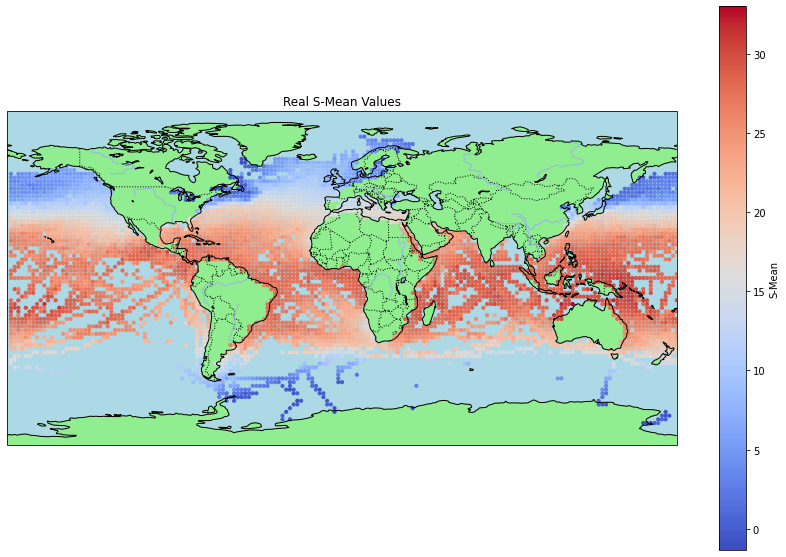

In [21]:
# Example code to plot predicted SST values on a map using Cartopy
plot_world_map(dataset_test, 'S-Mean', 'Real S-Mean Values', dataset_test['S-Mean'])